<h1>Import Libraries</h1>

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import h5py
import seaborn as sns

In [3]:
sys.path.append("../../WatChMaL_analysis_copy")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc, compute_roc, plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output, collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_mu_fq_output, load_pion_fq_output, load_gamma_fq_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices
from WatChMaL.analysis.performance_analysis_plot_utils import plot_fitqun_binned_performance, plot_momentum_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_true_momentum_binned_performance, plot_to_wall_binned_performance, plot_energy_binned_performance, plot_zenith_binned_performance, plot_azimuth_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_in_energy, plot_zenith_binned_in_azimuth, plot_azimuth_binned_in_zenith

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi 0$":3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:"$\pi 0$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

<h1>Load fiTQun Results</h1>

In [5]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
pion_file_path  = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

fq_mapping_path = '/home/zpatel/zp_analysis_notebooks/cuts/4_class_3M_fitqun_mapping.pickle'

with open('/home/zpatel/zp_analysis_notebooks/cuts/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

In [6]:
############# define run locations #############
_4_class_locs = [
        '/home/zpatel/WatChMaL/outputs/2021-06-16/10-49-03/outputs', #JT weights trained on Jt test config
                    '/home/zpatel/WatChMaL/outputs/2021-07-21/10-47-52/outputs' #padded data

]

_2_class_locs = [
    '/home/zpatel/WatChMaL/outputs/2021-07-28/12-05-43/outputs' #JT 2-class weights tested on JT test

]

short_locs = _4_class_locs + _2_class_locs



# short_locs = [
# #                 '/home/zpatel/WatChMaL/outputs/2021-06-07/09-32-54/outputs', #ZP run #1 
# #                 '/home/zpatel/WatChMaL/outputs/2021-06-14/09-33-32/outputs',  #ZP run #2
# #                 '/home/zpatel/WatChMaL/outputs/2021-06-14/10-02-07/outputs',   #ZP run #3
# #                     '/home/zpatel/zp_analysis_notebooks/JT_4_class_training/outputs', #JT outputs from full config file (train and test) but doesn't work (different length arrays)
# #                   '/home/zpatel/WatChMaL/outputs/2021-06-14/13-27-06/outputs',  #JT weights with ZP testing config
# #                 '/home/zpatel/zp_analysis_notebooks/outputs_4_class_JT/',     #JT 4-class
# #                 '/home/zpatel/WatChMaL/outputs/2021-06-15/10-30-10/outputs', #ZP weights (ZP train/test config) with JT testing 
# #                 '/home/zpatel/WatChMaL/outputs/2021-06-16/09-59-14/outputs', #ZP weights using JT train/test config, JT test config
#                 '/home/zpatel/WatChMaL/outputs/2021-06-16/10-49-03/outputs', #JT weights trained on Jt test config
# #                 '/home/zpatel/WatChMaL/outputs/2021-06-29/12-02-12/outputs', #ZP weights with padding
# #                     '/home/zpatel/WatChMaL/outputs/2021-07-16/10-00-28/outputs', #ZP weights trained on Jt train/test config with padding, with correct horiz padding
# #                 '/home/zpatel/WatChMaL/outputs/2021-07-21/10-47-52/outputs', #padded data
# #                 '/home/zpatel/zp_analysis_notebooks/outputs_2_class_JT/'     #JT 2-class
# #                 '/home/zpatel/WatChMaL/outputs/2021-07-28/10-02-25/outputs', #ZP 2-class (JT train/test config)
#                 '/home/zpatel/WatChMaL/outputs/2021-07-28/12-05-43/outputs' #JT 2-class weights tested on JT test
#               ]

short_titles = ['Short Tank (4-class)','Short Tank (2-class)', 'Short Tank (2-class)', 'Fitqun'] # Includes 2-Class

full_locs = []

full_titles = []

short_linecolor = [c[0] for _ in range(len(short_locs))]
short_linestyle = ['--' for _ in range(len(short_locs))]

full_linecolor = [c[1] for _ in full_locs]
full_linestyle = [':' for _ in full_locs]

In [7]:
############# load short tank run data #############
short_raw_output_softmax_4_class    = [np.load(loc + "/softmax.npy") for loc in _4_class_locs]
short_raw_output_softmax_2_class    = [np.load(loc + "/softmax.npy") for loc in _2_class_locs]
short_raw_output_softmax            = short_raw_output_softmax_4_class + short_raw_output_softmax_2_class

short_raw_actual_labels_4_class     = [np.load(loc + "/labels.npy") for loc in _4_class_locs]
short_raw_actual_labels_2_class     = [np.load(loc + "/labels.npy") for loc in _2_class_locs]
short_raw_actual_labels             = short_raw_actual_labels_4_class + short_raw_actual_labels_2_class

raw_indices_4_class = [np.load(loc + "/indices.npy") for loc in _4_class_locs]
raw_indices_2_class = [np.load(loc + "/indices.npy") for loc in _2_class_locs]
raw_indices = raw_indices_4_class + raw_indices_2_class

In [8]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

<h1>Load h5 Data</h1>

In [11]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

energies   = np.array(data_file['energies'])
angles     = np.array(data_file['angles'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


Reorder any data to be used later.

In [12]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs  = idxs['test_idxs']

test_angles    = angles[test_idxs][raw_indices[0]]
test_energies  = energies[test_idxs][raw_indices[0]]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]

In [13]:
test_energies.shape

(4671749, 1)

Reorder test labels.

In [14]:
test_labels = test_labels[raw_indices[0]]

Both <Code>test_d_to_wall</Code> and <Code>test_true_mom</Code> must have their indices swapped to match the 4-class model softmax order. 

In [15]:
d_to_wall = np.load('/home/zpatel/WatChMaL_analysis_copy/fitqun_comparison/fitqun_comparison_prep/prep_data/3M_d_to_wall.npz', allow_pickle=True)

test_d_to_wall  = d_to_wall['test_d_to_wall'][raw_indices[0]]

In [16]:
true_mom = np.load('/home/zpatel/WatChMaL_analysis_copy/fitqun_comparison/fitqun_comparison_prep/prep_data/3M_momenta.npz', allow_pickle=True)

test_true_mom  = true_mom['test_momenta'][raw_indices[0]]

<h1>Verify Indices</h1>

In [17]:
e_gamma_4_class_idxs = np.where((test_labels == 0) | (test_labels == 1))[0]

In [18]:
len(e_gamma_4_class_idxs)

2360343

In [19]:
print('4 class labels:')
for short_raw_labels in short_raw_actual_labels_4_class:
    print(np.bincount(short_raw_labels))

print('\n2 class labels')
for short_raw_labels in short_raw_actual_labels_2_class:
    print(np.bincount(short_raw_labels))

print('\nTest labels')

print(np.bincount(test_labels))
print(np.bincount(test_labels[e_gamma_4_class_idxs]))

4 class labels:
[1182377 1177966 1164139 1147267]
[1182377 1177966 1164139 1147267]

2 class labels
[1182377 1177966]

Test labels
[1182377 1177966 1164139 1147267]
[1182377 1177966]


## Generate Muon Rejection Based Preselection

### Load 4-class with muons

In [20]:
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

In [21]:
muon_cut_to_apply = cuts['fq_comparison_swap']

muon_raw_short_softmax = short_raw_output_softmax_4_class

muon_filtered_short_softmax = []
muon_filtered_labels = []
muon_collapsed_class_scores, muon_collapsed_class_labels = [], []

for i in range(len(short_raw_output_softmax_4_class)):
    muon_filtered_short_softmax.append(remove_indices(short_raw_output_softmax_4_class[i], muon_cut_to_apply))
    muon_filtered_labels.append(remove_indices(short_raw_actual_labels_4_class[i], muon_cut_to_apply))
    
    collapsed_scores, collapsed_labels = collapse_test_output(muon_filtered_short_softmax[i], muon_filtered_labels[i], label_dict, ignore_type='$\gamma$')
    
    muon_collapsed_class_scores.append(collapsed_scores) 
    muon_collapsed_class_labels.append(collapsed_labels)

    muon_collapsed_class_scores[i] = muon_collapsed_class_scores[i][:,1:]
    muon_collapsed_class_labels[i] = muon_collapsed_class_labels[i] - 1 

In [27]:
print('Labels:', label_dict)
for i in range(len(muon_filtered_short_softmax)):
    print('\nFiltered Softmax and Filtered Label shape(s) for 4-class iteration {}:'.format(i))
    print(muon_filtered_short_softmax[i].shape, muon_filtered_labels[i].shape)
    print('\nMuon collapsed label length(s) for 4-class iteration {}:'.format(i))
    print(len(muon_collapsed_class_labels[i]))



Labels: {'$\\gamma$': 0, '$e$': 1, '$\\mu$': 2, '$\\pi 0$': 3}

Filtered Softmax and Filtered Label shape(s) for 4-class iteration 0:
(1983641, 4) (1983641,)

Muon collapsed label length(s) for 4-class iteration 0:
1005732

Filtered Softmax and Filtered Label shape(s) for 4-class iteration 1:
(1983641, 4) (1983641,)

Muon collapsed label length(s) for 4-class iteration 1:
1005732


<h1>Cuts</h1>

<h2>Compute Thresholds</h2>

In [28]:
fpr_fixed_point = 0.005

fprs, tprs, thrs = [], [], []
operating_point_thr = []
operating_point_cut = []

for i in range(len(muon_collapsed_class_scores)):
    fprs_val, tprs_val, thrs_val = compute_roc(muon_collapsed_class_scores[i], muon_collapsed_class_labels[i],
                                true_label=muon_softmax_index_dict["e/gamma"],
                                false_label=muon_softmax_index_dict["mu"],
                                normalize=True)
    fprs.append(fprs_val)
    tprs.append(tprs_val)
    thrs.append(thrs_val)
    
    operating_point_thr.append(thrs[i][np.argmin(np.abs(fprs[i] - fpr_fixed_point))])

    operating_point_cut.append(((muon_raw_short_softmax[i][:, 0] + muon_raw_short_softmax[i][:, 1])/(muon_raw_short_softmax[i][:, 0] + muon_raw_short_softmax[i][:, 1] + muon_raw_short_softmax[i][:, 2])) < operating_point_thr[i])
    print('\nRates for 4-class iteration {}'.format(i))
    print('True Positive Rate: ', tprs[i][np.argmin(np.abs(fprs[i] - fpr_fixed_point))])
    print('False Positive Rate: ', fprs[i][np.argmin(np.abs(fprs[i] - fpr_fixed_point))]) 


Rates for 4-class iteration 0
True Positive Rate:  0.9848511202371384
False Positive Rate:  0.004998335338905415

Rates for 4-class iteration 1
True Positive Rate:  0.9886154539079679
False Positive Rate:  0.0050005113664800364


<h2>Verify Cuts</h2>

In [29]:
comp_idxs = []
scores = []
pred_pos_idxs = []
pred_neg_idxs = []

for i in range(len(muon_filtered_labels)):
    comp_idxs.append(np.where((muon_filtered_labels[i] == 1 ) | (muon_filtered_labels[i] == 2))[0])

    scores.append(((muon_filtered_short_softmax[i][:, 0] + muon_filtered_short_softmax[i][:, 1])/(muon_filtered_short_softmax[i][:, 0] + muon_filtered_short_softmax[i][:, 1] + muon_filtered_short_softmax[i][:, 2])))

    pred_pos_idxs.append(np.where( scores[i][comp_idxs[i]] >= operating_point_thr[i])[0])
    pred_neg_idxs.append(np.where( scores[i][comp_idxs[i]] < operating_point_thr[i])[0])

    true_label, false_label = '$e$','$\mu$'
    
    fp = np.where(muon_filtered_labels[i][comp_idxs[i][pred_pos_idxs[i]]] == label_dict[false_label])[0].shape[0]
    tp = np.where(muon_filtered_labels[i][comp_idxs[i][pred_pos_idxs[i]]] == label_dict[true_label] )[0].shape[0]
    fn = np.where(muon_filtered_labels[i][comp_idxs[i][pred_neg_idxs[i]]] == label_dict[true_label] )[0].shape[0]
    tn = np.where(muon_filtered_labels[i][comp_idxs[i][pred_neg_idxs[i]]] == label_dict[false_label])[0].shape[0]

    # Fix division by zero
    efficiency = performance = tp/(tp + fn + 1e-10)
    fpr = performance = fp/(fp + tn + 1e-10)
    
    print('\n4-Class iteration {}'.format(i))
    print('Efficiency: ', efficiency)
    print('False Positive Rate: ', fpr)


4-Class iteration 0
Efficiency:  0.9848511202371382
False Positive Rate:  0.004998335338905414

4-Class iteration 1
Efficiency:  0.9886154539079677
False Positive Rate:  0.005000511366480035


<h2>Plot ROC</h2>

In [49]:
cut_to_apply = cuts['fq_comparison_swap']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

In [50]:
muon_preselection_short_softmax = []
muon_preselection_filtered_labels = []
_4_class_inds = len(short_raw_output_softmax_4_class)

for i in range(_4_class_inds):
    muon_preselection_short_softmax.append(remove_indices(short_raw_output_softmax[i][e_gamma_4_class_idxs], cut_to_apply))
    muon_preselection_filtered_labels.append(remove_indices(short_raw_actual_labels[i][e_gamma_4_class_idxs], cut_to_apply))

In [51]:
fpr_list = [] 
tpr_list = []
thr_list = []

for i in range(len(muon_preselection_short_softmax)):
    fprs, tprs, thrs = compute_roc(muon_preselection_short_softmax[i], muon_preselection_filtered_labels[i], 
                                true_label=label_dict["$e$"], 
                                false_label=label_dict["$\gamma$"],
                                normalize=True)
    
    fpr_list.append(fprs)
    tpr_list.append(tprs)
    thr_list.append(thrs)

In [52]:
gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank ResNet (4-Class) Padded', 'Short Tank Fitqun 1', 'Short Tank Fitqun 2', 'Short Tank Fitqun 3']

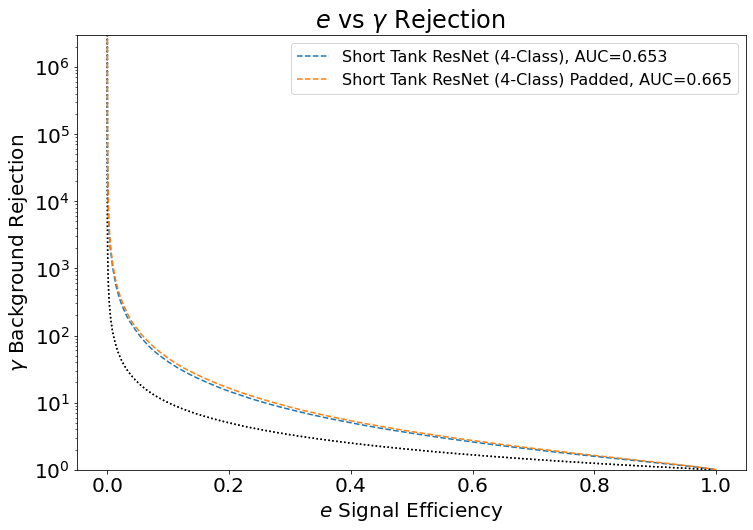

In [53]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

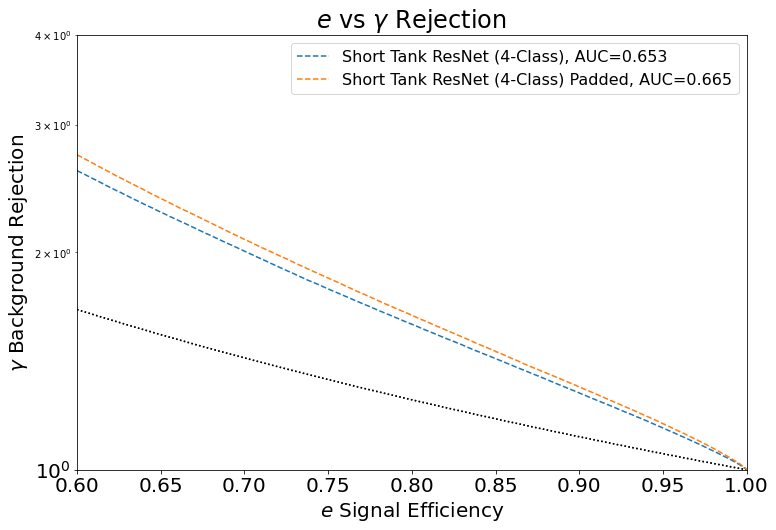

In [54]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

<h3>With Muon Preselection</h3>

In [55]:
len(muon_preselection_short_softmax)

2

In [56]:
for i in range(2):
    print(i)

0
1


In [57]:
cuts_to_apply = cuts['fq_comparison_swap']
updated_cuts = []
cut_to_apply = []
pre_muon_cuts = []
for i in range(len(muon_preselection_short_softmax)):
    print(i)
    updated_cuts.append(np.zeros_like(test_labels, dtype=bool))
    updated_cuts[i][cuts_to_apply] = True

    pre_muon_cuts.append(np.where(updated_cuts[i][e_gamma_4_class_idxs])[0])

    updated_cuts[i][operating_point_cut[i]] = True  
        
    cut_to_apply.append(np.where(updated_cuts[i][e_gamma_4_class_idxs])[0])

fpr_list = [] 
tpr_list = []
thr_list = []

muon_preselection_short_softmax = []
muon_preselection_filtered_labels = []

for i in range(_4_class_inds):
# Compute preslection factors
    pre_muon_preselection_labels  = remove_indices(short_raw_actual_labels[i][e_gamma_4_class_idxs], pre_muon_cuts[i])
    post_muon_preselection_labels = remove_indices(short_raw_actual_labels[i][e_gamma_4_class_idxs], cut_to_apply[i])

    print('\n4-Class iteration {}'.format(i))
    print('Pre-Muon label length: ', len(pre_muon_preselection_labels))
    print('Post-Muon label length: ', len(post_muon_preselection_labels))

# Electron
    efficiency_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 1]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 1])

    print('Efficiency correction factor', efficiency_correction_factor)

# Gamma
    rejection_correction_factor = len(post_muon_preselection_labels[post_muon_preselection_labels == 0]) / len(pre_muon_preselection_labels[pre_muon_preselection_labels == 0])

    print('Rejection Correction Factor', rejection_correction_factor)

    muon_preselection_short_softmax.append(remove_indices(short_raw_output_softmax[i][e_gamma_4_class_idxs], cut_to_apply[i]))
    muon_preselection_filtered_labels.append(remove_indices(short_raw_actual_labels[i][e_gamma_4_class_idxs], cut_to_apply[i]))
    
    fprs, tprs, thrs = compute_roc(muon_preselection_short_softmax[i], muon_preselection_filtered_labels[i], 
                                true_label=label_dict["$e$"], 
                                false_label=label_dict["$\gamma$"],
                                normalize=True)

    # Update using preselection statistics
    tprs = tprs*efficiency_correction_factor
    fprs = fprs*rejection_correction_factor
    
    fpr_list.append(fprs)
    tpr_list.append(tprs)
    thr_list.append(thrs)

0
1

4-Class iteration 0
Pre-Muon label length:  1101872
Post-Muon label length:  1089135
Efficiency correction factor 0.9848511202371384
Rejection Correction Factor 0.9919685869715832

4-Class iteration 1
Pre-Muon label length:  1101872
Post-Muon label length:  1092404
Efficiency correction factor 0.9886154539079679
Rejection Correction Factor 0.9941514469320291


In [58]:
gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank ResNet (4-Class) Padded', 'Short Tank Fitqun 1', 'Short Tank Fitqun 2', 'Short Tank Fitqun 3']

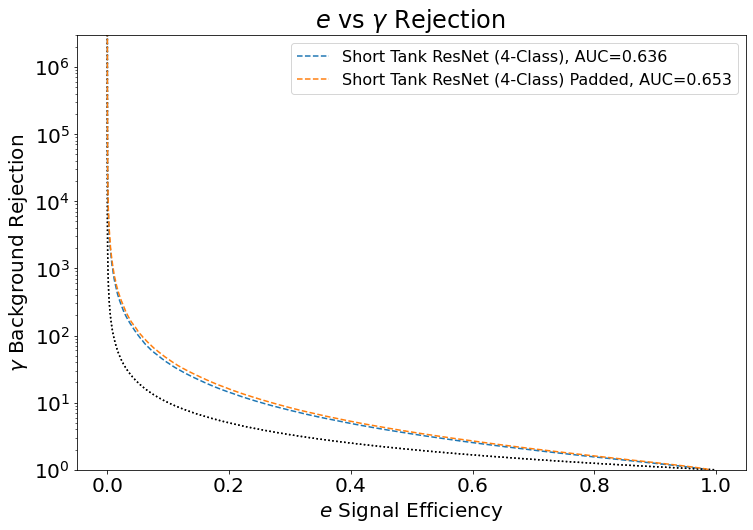

In [59]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

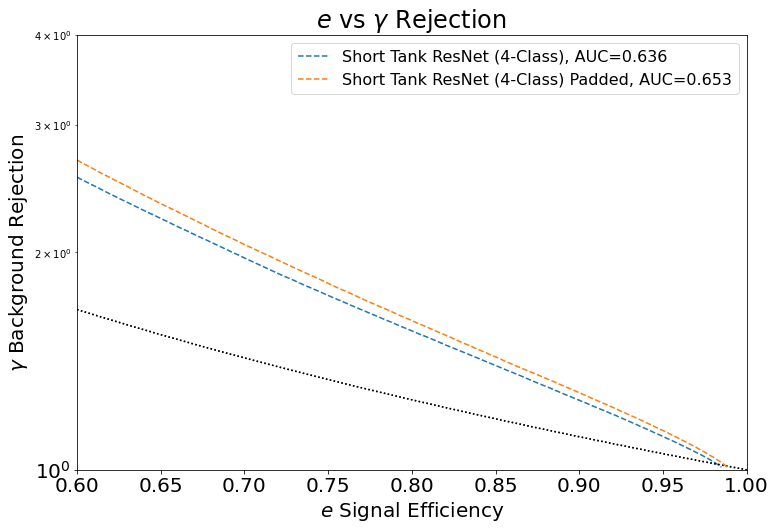

In [60]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

<h1>Plot Performance</h1>

<h2>Adding fiTQun Results</h2>

fiTQun results must be reordered to match indices.npy order.


In [199]:
fq_scores, fq_labels, fq_mom, fq_masses = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')
fq_scores = fq_scores[raw_indices[0]]
fq_labels = fq_labels[raw_indices[0]]
fq_mom = fq_mom[raw_indices[0]]
fq_masses = fq_masses[raw_indices[0]]

In [220]:
short_output_softmax_4_class = []
short_actual_labels_4_class = []

short_output_softmax_2_class = []
short_actual_labels_2_class = []

_2_class_inds = len(short_raw_output_softmax_2_class)

for i in range(_4_class_inds):
    short_output_softmax_4_class.append(short_raw_output_softmax[i][e_gamma_4_class_idxs])
    short_actual_labels_4_class.append(short_raw_actual_labels[i][e_gamma_4_class_idxs])

for i in range(_2_class_inds):
    short_output_softmax_2_class.append((short_raw_output_softmax[_4_class_inds + i]))
    short_actual_labels_2_class.append(short_raw_actual_labels[_4_class_inds + i])
    
short_output_softmax = short_output_softmax_4_class + short_output_softmax_2_class + [fq_scores[e_gamma_4_class_idxs]]
short_actual_labels  = short_actual_labels_4_class + short_actual_labels_2_class + [fq_labels[e_gamma_4_class_idxs]]

In [224]:
cut_to_apply = cuts['fq_comparison_swap']

updated_cuts = np.zeros_like(test_labels, dtype=bool)
updated_cuts[cut_to_apply] = True
updated_cuts[operating_point_cut] = True

cut_to_apply = np.where(updated_cuts[e_gamma_4_class_idxs])[0]

<ipython-input-224-18d9ff5254f0>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  updated_cuts[operating_point_cut] = True


In [280]:
filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_energies  = remove_indices(test_energies[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_angles    = remove_indices(test_angles[e_gamma_4_class_idxs], cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_4_class = []
scores_2_class = []
names = []
for i in range(_4_class_inds):
    scores_4_class.append((filtered_short_softmax[i][:,1])/(filtered_short_softmax[i][:,0] + filtered_short_softmax[i][:,1]))
    names.append('ResNet (4-Class) - #{}'.format(i))
for i in range(_2_class_inds):
    scores_2_class.append((filtered_short_softmax[i + _4_class_inds][:,1])/(filtered_short_softmax[i + _4_class_inds][:,0] + filtered_short_softmax[i + _4_class_inds][:,1]))
    names.append('ResNet (2-Class) - #{}'.format(i))

scores_fitqun = filtered_short_softmax[-1][:,1]

scores_list = scores_4_class + scores_2_class + [scores_fitqun]

labels_list = filtered_labels
names.append('FiTQun')
# colors = ['r', 'b', 'g']
clrs = sns.color_palette('bright', n_colors=len(scores_list))  # a list of RGB tuples

fpr_rate = 0.2

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$e$ Signal Efficiency'>

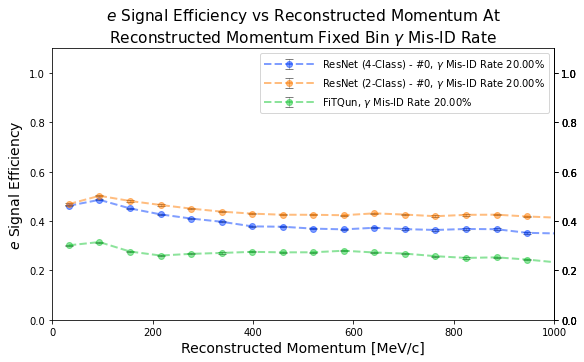

In [281]:
plot_momentum_binned_performance(
                                 reconstructed_momentum = filtered_fq_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = clrs,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='To Wall [cm]', ylabel='$e$ Signal Efficiency'>

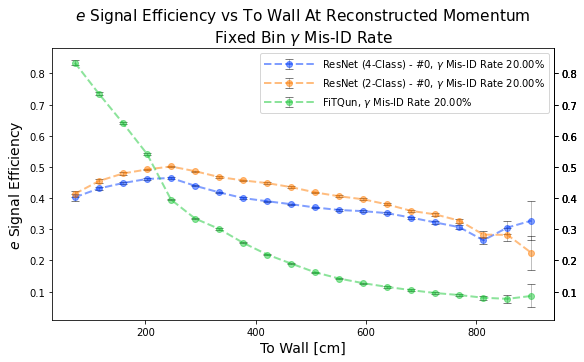

In [282]:
plot_to_wall_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 to_wall_features       = filtered_test_to_wall,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = clrs,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

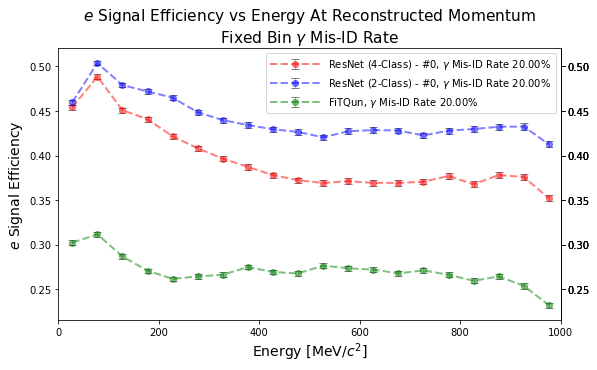

In [283]:
plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000],
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Zenith [Radians]', ylabel='$e$ Signal Efficiency'>

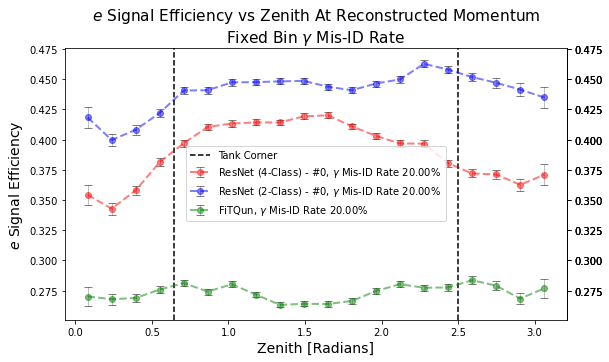

In [284]:
plot_zenith_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 zenith_features        = filtered_test_zenith,
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

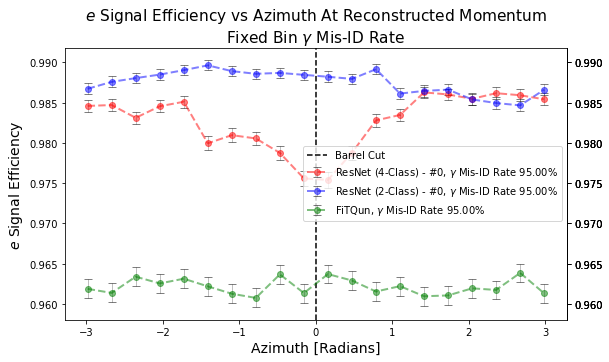

In [285]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.95, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

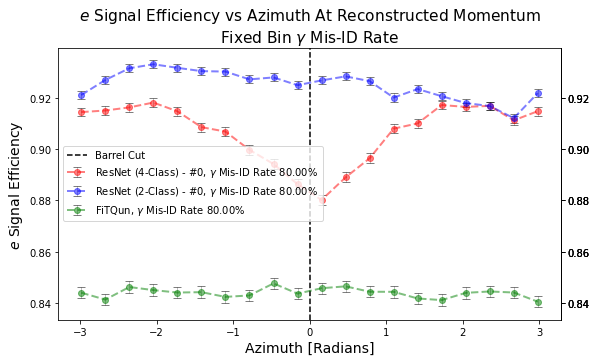

In [286]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.8, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

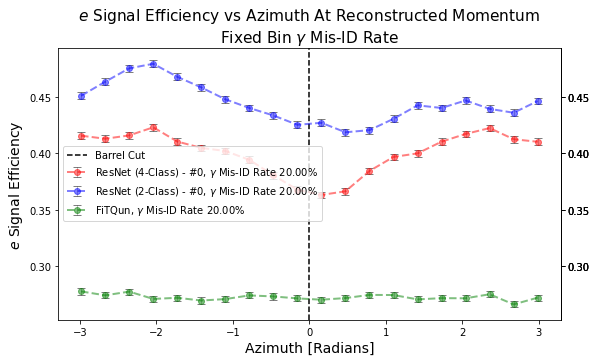

In [287]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.2, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

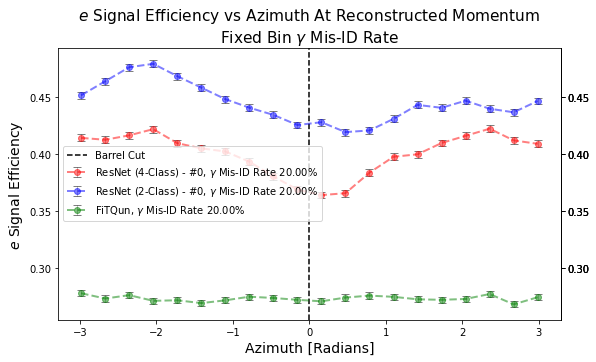

In [288]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_test_true_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.2, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

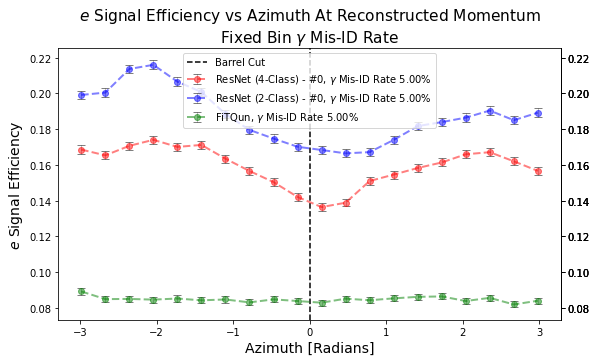

In [289]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.05, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )